<a href="https://colab.research.google.com/github/djakesa/AE-VAE-GAN-CelebA/blob/main/morphing_smile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from google.colab import drive
import os
import shutil

# Démontage s'il est déjà monté
try:
    !fusermount -u /content/drive
except:
    pass

# Suppression du dossier de montage s'il reste
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive', ignore_errors=True)

# Montage propre
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

attr_file = "/content/drive/MyDrive/CelebA/Anno/list_attr_celeba.txt"
attrs = pd.read_csv(attr_file, sep="\s+", skiprows=1)

In [ ]:
# Sélectionne 300 visages chauve et 300 sans
n = 300
with_bald = attrs[attrs["Bald"] == 1].sample(n, random_state=42)
without_bald = attrs[attrs["Bald"] == -1].sample(n, random_state=42)


In [ ]:
import cv2

def load_and_preprocess(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    return img


In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
import tensorflow as tf
import numpy as np
import os
import json

# Learning rate scheduler
def step_decay_schedule(initial_lr, decay_factor=0.8, step_size=50):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return LearningRateScheduler(schedule, verbose=1)

class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu), mean=0.0, stddev=1.0)
        z = mu + tf.exp(0.5 * log_var) * epsilon

        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)
        kl_mean = tf.reduce_mean(kl_loss)
        self.add_loss(80*kl_mean)
        return z

class Decodeur_learnable(Layer):
    def __init__(self, **kwargs):
        super(Decodeur_learnable, self).__init__(**kwargs)
        self.log_var = self.add_weight(
            name='log_var',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        y_true, y_pred = inputs
        var = tf.clip_by_value(tf.exp(self.log_var), 1e-3, 100.0)
        n = tf.cast(tf.reduce_prod(tf.shape(y_true)[1:]), tf.float32)
        mse = tf.reduce_sum(tf.square(y_true - y_pred), axis=[1, 2, 3])

        log_likelihood = - (n / 2) * tf.math.log(2 * np.pi) - (n / 2) * tf.math.log(var) - mse / (2 * var)
        neg_log_likelihood = -tf.reduce_mean(log_likelihood)
        self.add_loss(neg_log_likelihood)
        return y_pred

class FeatureLossVGG(Layer):
    def __init__(self, **kwargs):
        super(FeatureLossVGG, self).__init__(**kwargs)
        vgg = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
        vgg.trainable = False
        selected_layers = ['block1_conv2', 'block2_conv1', 'block3_conv1']
        self.vgg_model = Model(inputs=vgg.input, outputs=[vgg.get_layer(name).output for name in selected_layers])

    def call(self, inputs):
        y_true, y_pred = inputs
        y_true_pp = preprocess_input(y_true * 255.0)
        y_pred_pp = preprocess_input(y_pred * 255.0)
        f_true = self.vgg_model(y_true_pp)
        f_pred = self.vgg_model(y_pred_pp)

        loss = 0.0
        for ft, fp in zip(f_true, f_pred):
            loss += tf.reduce_mean(tf.square(ft - fp))

        self.add_loss(0.5*loss)
        return y_pred

class VAE():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size,
                 decoder_conv_t_strides, z_dim, use_batch_norm=False, use_dropout=True):

        self.name = 'variational_autoencoder'
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        encoder_input = Input(shape=self.input_dim, name="encoder_input_layer")
        y_true_input = Input(shape=self.input_dim, name="reconstruction_target")
        x = encoder_input

        for i in range(self.n_layers_encoder):
            x = Conv2D(filters=self.encoder_conv_filters[i],
                       kernel_size=self.encoder_conv_kernel_size[i],
                       strides=self.encoder_conv_strides[i],
                       padding='same',
                       name=f'encoder_conv_{i}')(x)
            if self.use_batch_norm:
                x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            if self.use_dropout:
                x = Dropout(0.1)(x)

        self.shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        mu = Dense(self.z_dim, name='mu')(x)
        log_var = Dense(self.z_dim, name='log_var')(x)
        z = Sampling(name='encoder_output')([mu, log_var])

        self.encoder = Model(encoder_input, z)

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        x = Dense(np.prod(self.shape_before_flattening))(decoder_input)
        x = Reshape(self.shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            x = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                                kernel_size=self.decoder_conv_t_kernel_size[i],
                                strides=self.decoder_conv_t_strides[i],
                                padding='same',
                                name=f'decoder_conv_t_{i}')(x)
            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(0.1)(x)
            else:
                x = Activation('sigmoid')(x)

        self.decoder = Model(decoder_input, x)
        x_hat = self.decoder(self.encoder(encoder_input))

        decoded = Decodeur_learnable(name="log_likelihood_loss")([y_true_input, x_hat])
        final_output = FeatureLossVGG(name="vgg_feature_loss")([y_true_input, decoded])

        self.model = Model(inputs=[encoder_input, y_true_input], outputs=final_output)

    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer)

    def train(self, x_train, batch_size, epochs, initial_epoch=0, callbacks=None, lr_decay=0.8):
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=20)
        if callbacks is None:
            callbacks = []
        callbacks.append(lr_sched)

        dataset = tf.data.Dataset.from_tensor_slices(((x_train, x_train), None))
        dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        history = self.model.fit(
            dataset,
            shuffle=True,
            epochs=epochs,
            initial_epoch=initial_epoch,
            callbacks=callbacks
        )
        return history

    def save(self, path):
        os.makedirs(path, exist_ok=True)
        self.model.save(os.path.join(path, "vae_model.keras"), include_optimizer=False)
        self.encoder.save(os.path.join(path, "encoder_model.keras"), include_optimizer=False)
        self.decoder.save(os.path.join(path, "decoder_model.keras"), include_optimizer=False)
        config = {
            "input_dim": self.input_dim,
            "encoder_conv_filters": self.encoder_conv_filters,
            "encoder_conv_kernel_size": self.encoder_conv_kernel_size,
            "encoder_conv_strides": self.encoder_conv_strides,
            "decoder_conv_t_filters": self.decoder_conv_t_filters,
            "decoder_conv_t_kernel_size": self.decoder_conv_t_kernel_size,
            "decoder_conv_t_strides": self.decoder_conv_t_strides,
            "z_dim": self.z_dim,
            "use_batch_norm": self.use_batch_norm,
            "use_dropout": self.use_dropout
        }
        with open(os.path.join(path, "config.json"), "w") as f:
            json.dump(config, f)

    @classmethod
    def load(cls, path):
        with open(os.path.join(path, "config.json"), "r") as f:
            config = json.load(f)
        vae = cls(**config)
        custom_objects = {
            "Sampling": Sampling,
            "Decodeur_learnable": Decodeur_learnable,
            "FeatureLossVGG": FeatureLossVGG
        }
        vae.model = load_model(os.path.join(path, "vae_model.keras"), custom_objects=custom_objects, compile=False)
        vae.encoder = load_model(os.path.join(path, "encoder_model.keras"), custom_objects=custom_objects, compile=False)
        vae.decoder = load_model(os.path.join(path, "decoder_model.keras"), compile=False)
        return vae


In [9]:
img_dir = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'

vae = VAE.load("/content/drive/MyDrive/vae_celeba")

# === Fonction de chargement + vérification image ===
def load_and_preprocess(img_path):
    if not os.path.isfile(img_path):
        print(f"[ABSENT] {img_path}")
        return None
    img = cv2.imread(img_path)
    if img is None:
        print(f"[INVALIDE] {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    return img



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [18]:
#  DataFrame est déjà chargé

# === Sélectionne 300 visages souriants et 300 non souriants ===
try:
    with_smiling = attrs[attrs["Smiling"] == 1].sample(n, random_state=42)
    without_smiling = attrs[attrs["Smiling"] == -1].sample(n, random_state=42)
except KeyError:
    print("Column 'Smiling' not found in the attributes. Please check the attribute names in your data.")
    raise

# === Encodage des visages souriants ===
z_smiling = []
print("Encodage des visages souriants...")
for img_name in with_smiling.index:
    path = os.path.join(img_dir, img_name)
    img = load_and_preprocess(path)
    if img is None:
        continue
    z = vae.encoder.predict(np.expand_dims(img, axis=0))
    z_smiling.append(z[0])
z_smiling = np.array(z_smiling)

# === Encodage des visages non souriants ===
z_not_smiling = []
print("Encodage des visages non souriants...")
for img_name in without_smiling.index:
    path = os.path.join(img_dir, img_name)
    img = load_and_preprocess(path)
    if img is None:
        continue
    z = vae.encoder.predict(np.expand_dims(img, axis=0))
    z_not_smiling.append(z[0])
z_not_smiling = np.array(z_not_smiling)

# === Calcul de la direction "sourire" ===
direction_smiling = np.mean(z_smiling, axis=0) - np.mean(z_not_smiling, axis=0)

# === Sauvegarde dans Drive ===
np.save("/content/drive/MyDrive/direction_smiling.npy", direction_smiling)
print(" Direction 'Smiling' enregistrée avec succès.")


Encodage des visages souriants...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Encodage des visages non souriants...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
 Direction 'Smiling' enregistrée avec succès.


In [20]:
#  DataFrame est déjà chargé

# === Sélectionne 300 visages souriants et 300 non souriants ===
try:
    with_bald = attrs[attrs["Bald"] == 1].sample(n, random_state=42)
    without_bald = attrs[attrs["Bald"] == -1].sample(n, random_state=42)
except KeyError:
    print("Column 'Smiling' not found in the attributes. Please check the attribute names in your data.")
    raise

# === Encodage des visages souriants ===
z_bald = []
print("Encodage des visages chauves...")
for img_name in with_smiling.index:
    path = os.path.join(img_dir, img_name)
    img = load_and_preprocess(path)
    if img is None:
        continue
    z = vae.encoder.predict(np.expand_dims(img, axis=0))
    z_bald.append(z[0])
z_bald = np.array(z_bald)

# === Encodage des visages non souriants ===
z_not_bald = []
print("Encodage des visages non chauves...")
for img_name in without_smiling.index:
    path = os.path.join(img_dir, img_name)
    img = load_and_preprocess(path)
    if img is None:
        continue
    z = vae.encoder.predict(np.expand_dims(img, axis=0))
    z_not_bald.append(z[0])
z_not_bald = np.array(z_not_bald)

# === Calcul de la direction "sourire" ===
direction_bald = np.mean(z_bald, axis=0) - np.mean(z_not_bald, axis=0)

# === Sauvegarde dans Drive ===
np.save("/content/drive/MyDrive/direction_bald.npy", direction_bald)
print(" Direction 'Bald' enregistrée avec succès.")


Encodage des visages chauves...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Encodage des visages non chauves...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
 Direction 'Bald' enregistrée avec succès.


In [21]:
print (direction_bald)
print (direction_smiling)

[ 4.59420264e-01 -2.49724567e-01  4.85411555e-01 -1.12694681e-01
  1.06822185e-01 -3.76482308e-02  4.61500973e-01 -5.98274052e-01
  1.76329821e-01  8.56950641e-01 -2.38754660e-01 -4.86567229e-01
 -2.68992722e-01  7.43128955e-02  4.43587780e-01  7.25347042e-01
 -1.62089467e-01 -9.95360911e-02 -5.43031335e-01  2.41284609e-01
 -3.16220820e-01 -2.00278014e-01  7.22983778e-02 -5.26478052e-01
  9.09678042e-02 -2.43976757e-01  3.00045013e-01  5.50334513e-01
  2.09836155e-01  9.89518642e-01 -2.51757234e-01  8.94394517e-03
  7.54115283e-02 -1.82571381e-01 -5.94373941e-01 -1.67781115e-01
  1.78187385e-01  4.54967409e-01 -4.13316250e-01 -6.51632130e-01
 -7.92557001e-01  1.07078500e-01  9.75345969e-02 -1.30705929e+00
  1.38694048e-01 -5.80146194e-01  9.73512232e-02 -1.02457404e-03
  3.41281891e-02  3.55067849e-03  8.13069046e-02 -1.11610746e+00
  6.36745512e-01  2.51582742e-01 -6.18912399e-01 -5.14933825e-01
 -9.41704512e-01  6.91309452e-01  1.43172026e-01  2.34235018e-01
 -4.66862023e-01 -1.48529

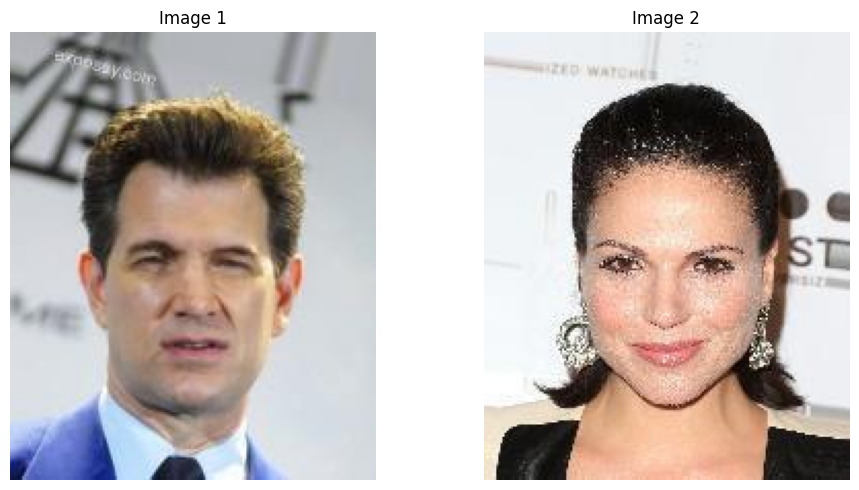

In [22]:
import cv2
import matplotlib.pyplot as plt

# === Chemins des deux images ===
img_path_1 = '/content/drive/MyDrive/img_align_celeba/img_align_celeba/000015.jpg'
img_path_2 = '/content/drive/MyDrive/img_align_celeba/img_align_celeba/005000.jpg'

# === Chargement et conversion RGB ===
img1 = cv2.imread(img_path_1)
img2 = cv2.imread(img_path_2)

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# === Affichage côte à côte ===
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title("Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


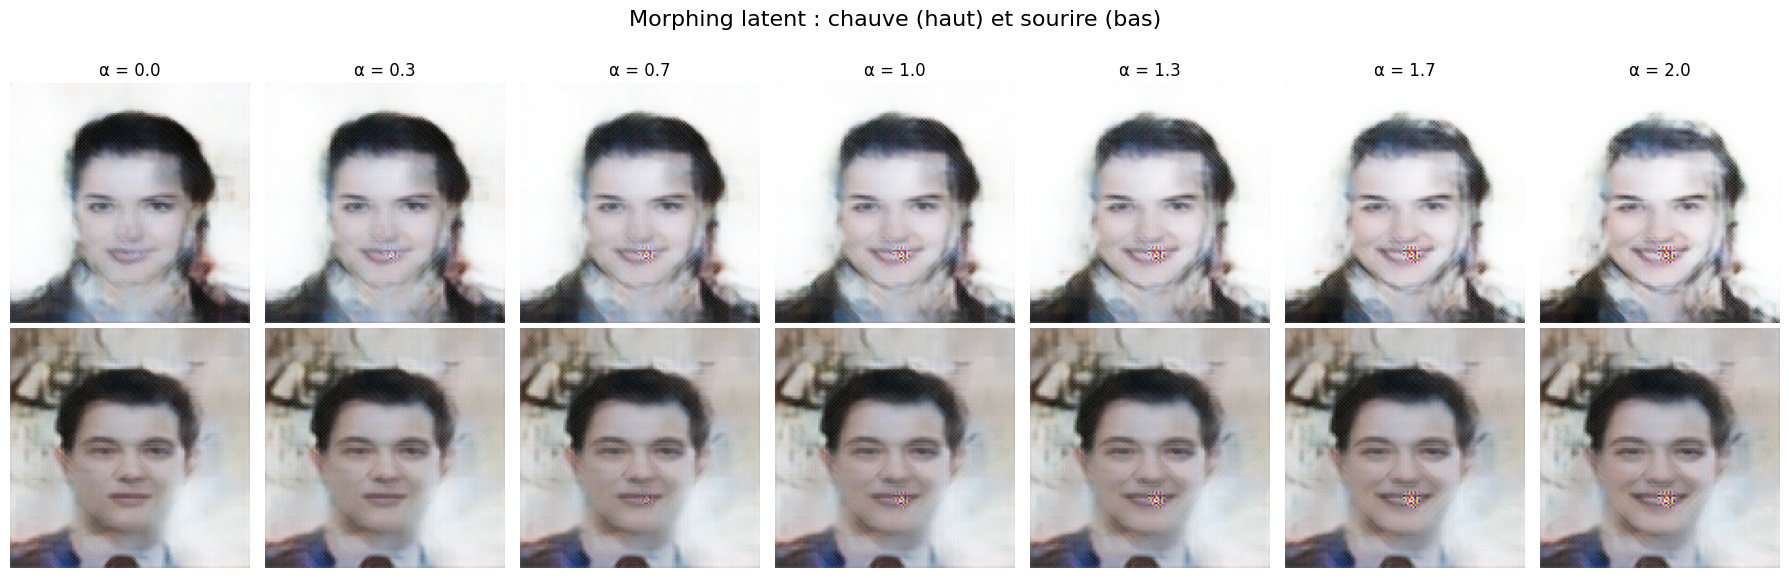

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Chemins ===
vae_model_dir = "/content/drive/MyDrive/vae_celeba"
direction_path_bald = "/content/drive/MyDrive/direction_bald.npy"
direction_path_smile = "/content/drive/MyDrive/direction_smile.npy"

#img_path_1 pour sourire
#img_path_2  pour chauve

# === Chargement du modèle et des directions ===
vae = VAE.load(vae_model_dir)
direction_bald = np.load(direction_path_bald)
direction_smile = np.load(direction_path_smile)

# === Chargement et encodage des deux images ===
img_sourire = load_and_preprocess(img_path_1)
img_chauve = load_and_preprocess(img_path_2)

if img_sourire is None or img_chauve is None:
    raise ValueError("Erreur de chargement des images.")

z_sourire = vae.encoder.predict(np.expand_dims(img_sourire, axis=0))[0]
z_chauve = vae.encoder.predict(np.expand_dims(img_chauve, axis=0))[0]

# === Morphing ===
alphas = np.linspace(0, 2, 7)

plt.figure(figsize=(18, 6))

# Ligne 1 : morphing chauve
for i, alpha in enumerate(alphas):
    z_morph_bald = z_chauve + alpha * direction_bald
    x_gen_bald = vae.decoder.predict(z_morph_bald[np.newaxis])[0]

    plt.subplot(2, len(alphas), i + 1)
    plt.imshow(x_gen_bald[..., ::-1])
    plt.axis('off')
    if i == 0:
        plt.ylabel("Chauve", fontsize=12)
    plt.title(f"α = {alpha:.1f}")

# Ligne 2 : morphing sourire
for i, alpha in enumerate(alphas):
    z_morph_smile = z_sourire + alpha * direction_smile
    x_gen_smile = vae.decoder.predict(z_morph_smile[np.newaxis])[0]

    plt.subplot(2, len(alphas), len(alphas) + i + 1)
    plt.imshow(x_gen_smile[..., ::-1])
    plt.axis('off')
    if i == 0:
        plt.ylabel("Sourire", fontsize=12)

plt.suptitle("Morphing latent : chauve (haut) et sourire (bas)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


# Inpainting


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


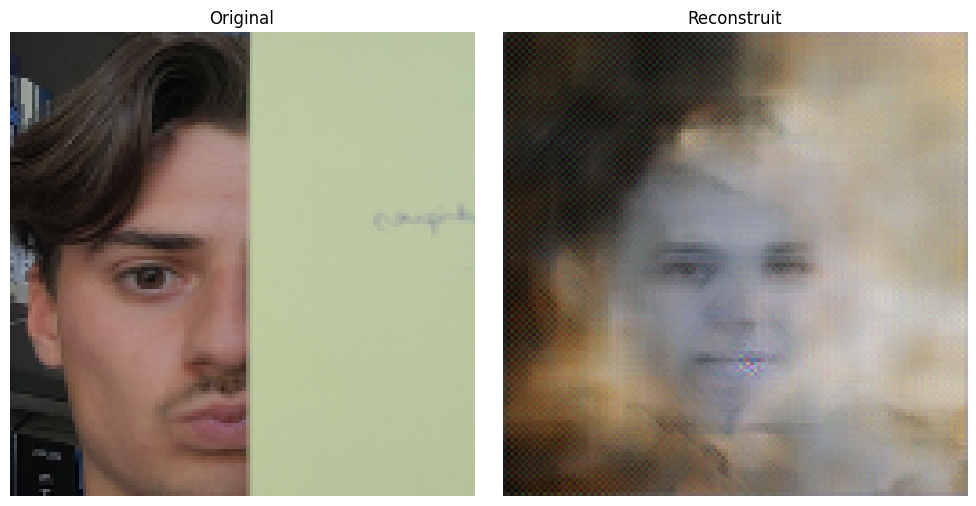

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os  # Import os for file checking

# === Fonction de chargement + vérification image ===
def load_and_preprocess(img_path):
    if not os.path.isfile(img_path):
        print(f"[ABSENT] {img_path}")
        return None
    img = cv2.imread(img_path)
    if img is None:
        print(f"[INVALIDE] {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Conversion BGR -> RGB
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    return img

# === Inpainting ===
img_path_inpainting = "/content/drive/MyDrive/John2.png"
test_imgs_input = load_and_preprocess(img_path_inpainting)

if test_imgs_input is None:
    raise ValueError(f"Erreur lors du chargement ou du prétraitement de l'image : {img_path_inpainting}")

test_imgs_input_batch = np.expand_dims(test_imgs_input, axis=0)

# Reconstruire avec le modèle
reconstructed_imgs_batch = vae.model.predict([test_imgs_input_batch, test_imgs_input_batch])
reconstructed_img = reconstructed_imgs_batch[0]  # Get the single reconstructed image


reconstructed_img = reconstructed_img
# Display the original and reconstructed images
plt.figure(figsize=(10, 5))

# Image originale
ax = plt.subplot(1, 2, 1)
plt.imshow((test_imgs_input * 255).astype(np.uint8))
plt.axis("off")
ax.set_title("Original")

# Image reconstruite
ax = plt.subplot(1, 2, 2)
plt.imshow((reconstructed_img * 255).astype(np.uint8))
plt.axis("off")
ax.set_title("Reconstruit")

plt.tight_layout()
plt.show()
